This project uses various sources of data about consumers, to help Automakers understand potential ways that their products can be improved to fit the needs of the owners. The datasets used are:
</br>

1. New York City Car Collisions - Located at the link:</br>
https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

2. eBay sales history for BMW parts - Collected with eBays "Finding" API.
https://developer.ebay.com/DevZone/finding/Concepts/FindingAPIGuide.html</br>

The following cell imports the required dependencies - the necessary "tools" and "toolboxes" to complete this project. It also reads-in the necessary files and datasets.

In [0]:
!pip install -U -q PyDrive
!pip install -U -q ebaysdk

# importing our dependencies
import time
import datetime
import traceback
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from google.colab import files
from ebaysdk.finding import Connection as finding
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter


# Code to read csv file int
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

sns.set()
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1YVVjQsM0QmiddT2DbUlMihSNFf2hZWqw'
myid = link.split('=')[1]
downloaded = drive.CreateFile({'id': myid}) 
downloaded.GetContentFile('nyc_collisions.csv')

link = 'https://drive.google.com/open?id=1yIPicjUGZQrPHB9DX8DCQTjANZZfLJZg'
myid = link.split('=')[1]
downloaded = drive.CreateFile({'id': myid}) 
downloaded.GetContentFile('ebayresults.csv')


link = 'https://drive.google.com/open?id=1n-QcaTMgyKveAcn760feOjoYonzg5pHB'
myid = link.split('=')[1]
downloaded = drive.CreateFile({'id': myid}) 
downloaded.GetContentFile('list_model.txt')
list_models = [
    line.lower().strip() for line in open('list_model.txt').readlines()]

# READING IN THE ORIGINAL DATAFRAME
df_original = pd.read_csv('nyc_collisions.csv', low_memory=False).drop_duplicates()
df = df_original.copy().sort_values(by='crash_date',axis=0,ascending=False)
df.dropna(subset=['on_street_name'],inplace=True,axis=0)
df_safe = df[
    (df['num_persons_injured']==0)&
    (df['num_persons_killed']==0)]
df_inj = df[df['num_persons_injured']>0]
df_kx = df[df['num_persons_killed']>0]

df_ebayoriginal = pd.read_csv(
    'ebayresults.csv', low_memory=False,).drop_duplicates()
df_ebay = df_ebayoriginal.copy()
df_ebay.drop('Unnamed: 0',inplace=True,axis=1)

def apply_model(value):
  try: model = [
      i for i in value.split(' ') if i in list_models][0]
  except: model = ' '
  return model
df_ebay['model'] = df_ebay.title.apply(apply_model)
df_cats = df_ebay.copy()[df_ebay.catname!='other']

df_models = df_cats.copy()[df_ebay.model != ' ']
df_models['modelcat'] = df_models.model.str.cat(df_models['catname'], sep='.')

"df" stands for "DataFrame," and is the original dataframe of NYC Automobile Collision data.
df_inj stands for "DataFrame_Injuries," and is a filtered subset of df. df_inj contains only rows that have atleast 1 injury reported. df_kx contains only rows that have atleast 1 death reported.
Below is the code for viewing some rows and columns of df_kx.

In [33]:
print('df Size: ' + str(df.shape[0]))
print('df_inj Size: ' + str(df_inj.shape[0]))
print('df_kx Size: ' + str(df_kx.shape[0]))
dfx.head()

df Size: 1642890
df_inj Size: 269658
df_kx Size: 1622


,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,num_persons_injured,num_persons_killed,num_pedestrians_injured,num_pedestrians_killed,num_cyclist_injured,num_cyclist_killed,num_motorist_injured,num_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
55325,2020-01-25 00:00:00,2020-01-29 06:30:00,manhattan,10013,40.716540,-73.996994,point (-73.996994 40.71654),canal street,elizabeth street,NaN,1.0,1.0,0.0,1.0,0.0,0,1.0,0.0,unspecified,NaN,NaN,NaN,NaN,4278630,station wagon/sport utility vehicle,NaN,NaN,NaN,NaN
53811,2020-01-25 00:00:00,2020-01-29 05:35:00,NaN,NaN,40.748398,-73.728790,point (-73.72879 40.748398),grand central pkwy,NaN,NaN,1.0,3.0,0.0,0.0,0.0,0,1.0,3.0,unsafe speed,unspecified,NaN,NaN,NaN,4278634,sedan,sedan,NaN,NaN,NaN
54889,2020-01-16 00:00:00,2020-01-29 09:04:00,brooklyn,11234,40.621216,-73.935390,point (-73.93539 40.621216),flatbush avenue,flatlands avenue,NaN,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0,pedestrian/bicyclist/other pedestrian error/co...,NaN,NaN,NaN,NaN,4274204,bus,NaN,NaN,NaN,NaN
55190,2020-01-16 00:00:00,2020-01-29 04:06:00,NaN,NaN,40.601948,-73.993820,point (-73.99382 40.601948),86 street,NaN,NaN,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0,unspecified,NaN,NaN,NaN,NaN,4274148,dump,NaN,NaN,NaN,NaN
61585,2020-01-15 00:00:00,2020-01-29 10:31:00,brooklyn,11205,40.688324,-73.964820,point (-73.96482 40.688324),saint james place,lafayette avenue,NaN,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0,failure to yield right-of-way,NaN,NaN,NaN,NaN,4273603,station wagon/sport utility vehicle,NaN,NaN,NaN,NaN


According to the official website, BMW Spartanburg produces Models "X3-X7". These models are similar to an SUV or Crossover. In the output below, we can see that SUV-like vehicles are the second-highest vehicle-type recorded in NYC vehicle collisions where atleast one injury or death has occured. This truth applies lots of pressure to automakers, by demanding an increase in SUV safety.

In [16]:
print('Most-frequent causes for injury:')
print(df_inj['vehicle_type_code_1'].value_counts().head(8))
print()
print('Most-frequent causes for death')
print(df_kx['vehicle_type_code_1'].value_counts().head(8))

Most-frequent causes for injury:
passenger vehicle                      111905
sport utility / station wagon           48712
sedan                                   30284
station wagon/sport utility vehicle     23613
taxi                                    12722
unknown                                  6472
pick-up truck                            4190
van                                      4066
Name: vehicle_type_code_1, dtype: int64

Most-frequent causes for death
passenger vehicle                      500
sport utility / station wagon          272
station wagon/sport utility vehicle    144
motorcycle                             131
sedan                                  112
bus                                     59
unknown                                 55
large com veh(6 or more tires)          45
Name: vehicle_type_code_1, dtype: int64


Below, we have three graphs representing 0 injuries, 1+ injuries, and 1+ deaths respectively. Based on the historical number of accidents on each of the top streets, it's not unreasonable to say that every driver on that street has a higher chance than normal of being involved in a collision for no reason other than being on a high-risk street / area.

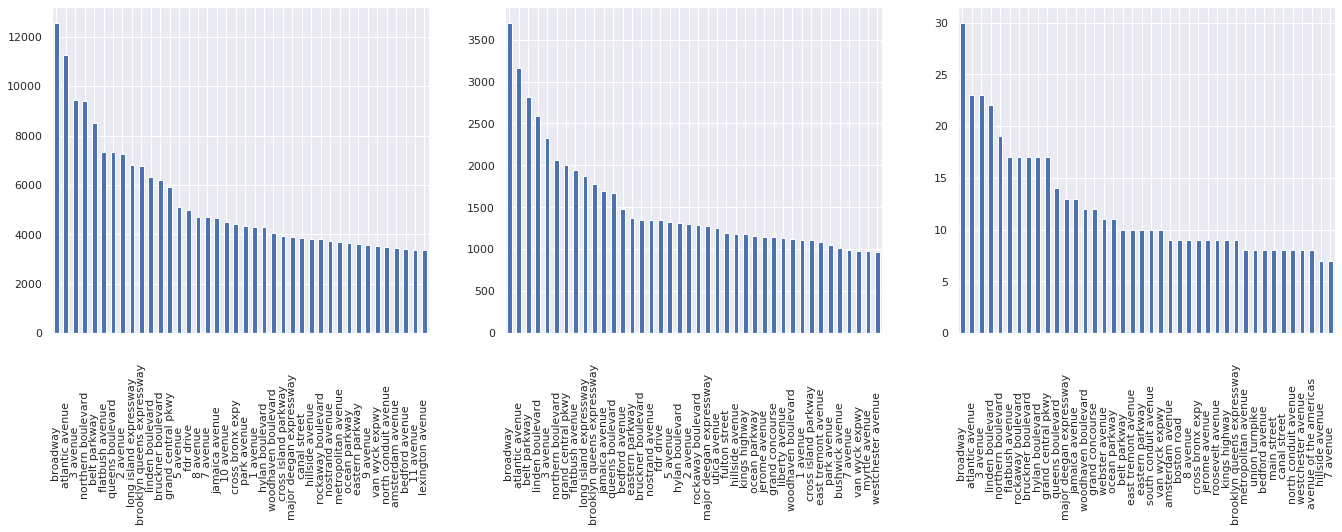

In [17]:
figure, (axis1, axis2, axis3) = plt.subplots(ncols=3)

df_safe['on_street_name'].value_counts().head(40).plot(kind='bar',figsize=(23,6),ax=axis1)
df_inj['on_street_name'].value_counts().head(40).plot(kind='bar',figsize=(23,6),ax=axis2)
df_kx['on_street_name'].value_counts().head(40).plot(kind='bar',figsize=(23,6),ax=axis3)

plt.show()

Why are all these crashes occurring, and what can we do about it?

Below, we have three graphs again representing 0 injuries, 1+ injuries, and 1+ deaths respectively. Across all three graphs, the number one cause is "Driver Inattention/Distraction", "Failure to yield", and "Unsafe speed" at the top 3 spots. 

It may be reasonable to predict collisions based on historical crash data of a location. If the on-board software can predict a high-risk situation based on location, maybe the car could illuminate a warning light to let the driver know to pay extra close attention because he's in a high-risk area, or a warning light for speeding etc.

It is a frightening reality that fatalities can be potentially be accurately predicted using this data, but it is a hopeful reality that we can prevent fatalities by using the data more efficiently.



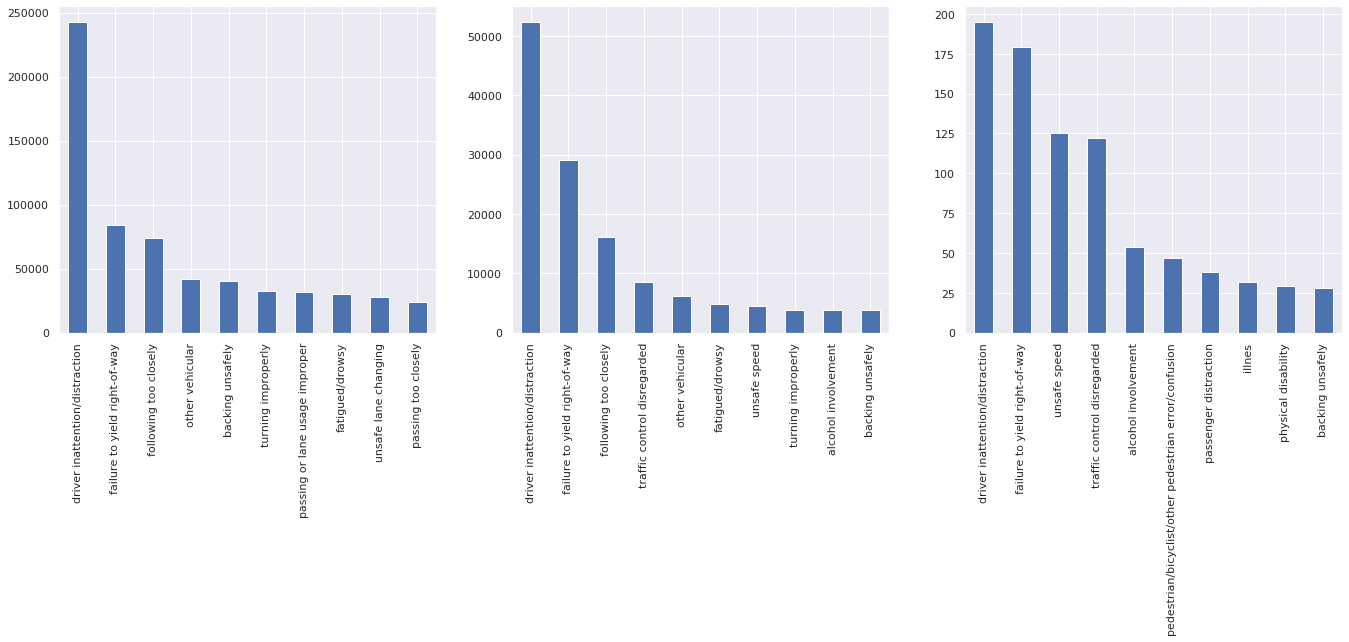

In [18]:
figure, (axis1, axis2, axis3) = plt.subplots(ncols=3)

df_collision_reasonsreasons = df[
    ~df['contributing_factor_vehicle_1']\
    .str.contains('unspecified',na=False)]
df_injury_reasonsreasons = df_collision_reasonsreasons[df_collision_reasonsreasons['num_persons_injured']>0]
df_killed_reasonsreasons = df_collision_reasonsreasons[df_collision_reasonsreasons['num_persons_killed']>0]

df_collision_reasonsreasons['contributing_factor_vehicle_1'].value_counts().head(10).plot(kind='bar',figsize=(23,6),ax=axis1)
df_injury_reasonsreasons['contributing_factor_vehicle_1'].value_counts().head(10).plot(kind='bar',figsize=(23,6),ax=axis2)
df_killed_reasonsreasons['contributing_factor_vehicle_1'].value_counts().head(10).plot(kind='bar',figsize=(23,6),ax=axis3)
plt.show()

Now lets shift gears, and take a look at the vibrant community of ebay auto parts. Trends in sales or consumer behavior could help us discover new ways to improve future products. This might also help identify what automotive systems may have been neglected in the engineering stages over the years.

In the following code cell, I use eBay's "Finding" API to collect the sales history of approximately 100,000 of the most-recent BMW parts sold on eBay. 

In [0]:
def get_ebay_data():
  # In this cell, we collect a large number of details about the sales history
  # of BMW Replacement parts
  global list_output, df_ebay
  list_output = []
  api = finding(
      appid='enntmepf-anblgife-PRD-9f8fe58ca-5a1431ef',
      config_file=None)
#       appid='enntmepf-anblgife-PRD-9f8fe58ca-5a1431ef',
#       appid='syeplkbe-rbnuifre-PRD-6f8fe589d-cd737eaf',
#       appid='jkjkfhjw-ntiennen-PRD-bf8fa4158-3a214d74',
      

  incrementor = 3
  for pricelow in range(0, 300, incrementor):
    maxpages = 101
    pricehigh = pricelow + incrementor - .01
    
    for page in range(1, 101): 
      if page > maxpages: continue
      if page % 5 == 0:
#         if pricelow % 10 == 0:
        print()
        print('Pricelow: ' + str(pricelow))
        print('Pricehigh: ' + str(pricehigh))
        print('Page: ' + str(page)) 
        print('Maxpages: ' + str(maxpages))
        print('Entries: ' + str(soup.totalentries.text))
        print('Added: ' + str(added))   
        print('Newtotal: ' + str(len(list_output)))

      Dictionary_ApiRequest = { 
        'keywords': 'bmw',
        'paginationInput': {'pageNumber': page},
        'categoryId': '6030',
        'sortOrder': 'EndTimeSoonest',
        'itemFilter': [
            {'name': 'MinPrice', 'paramName': 'USD', 'value': pricelow},
            {'name': 'MaxPrice', 'paramName': 'USD', 'value': pricehigh},
            {'name': 'LocatedIn', 'value': 'US'},
            {'name': 'SoldItemsOnly', 'value': True}]}
      try: response = api.execute('findCompletedItems', Dictionary_ApiRequest)
      except: traceback.print_exc(); continue

      added = 0
      soup = BeautifulSoup(response.text,'lxml')
      maxpages = int(soup.totalpages.text)
      for item in soup.find_all('item'):
        title = item.title.text.lower()
        catname = item.categoryname.text.lower()
        catcode = item.categoryid.text.lower()
        itemid = item.itemid.text
        list_output.append([title, catname, catcode, itemid])
        added += 1

  df_ebay = pd.DataFrame(list_output, columns=[
    'title','catname','catcode','itemid']).drop_duplicates()
  print('df_ebay shape: ' + str(df_ebay.shape))
  df_ebay.to_csv('output.csv',index='ignore')
  try: files.download('output.csv')
  except: print('failed to fetch.')
  
  
# get_ebay_data()

I am hypothesizing that there may be a high number of replacement auto parts purchased for BMW cars. The idea behind this hypothesis, is that a "surge" in sales might suggest a long-term flaw in  some engineering decisions. This data could be useful for deciding what systems in a car
might need more attention than others. Lets view the first few rows of this eBay dataset. Each row represents

In [20]:
df_models.head()

,title,catname,catcode,itemid,model,modelcat
3,bmw e46 m3 convertible oem power antenna modu...,antennas,33639,151151419714,m3,m3.antennas
4,2001-2006 bmw e46 m3 330ci convertible top lid...,"sunroof, convertible & hardtop",33652,151493560572,m3,"m3.sunroof, convertible & hardtop"
5,2001-2006 bmw e46 m3 3 series convertible righ...,sun visors,46102,152806374915,m3,m3.sun visors
6,2013-2016 bmw f80 f82 f83 m3 m4 front left mir...,mirrors,33649,174164180443,m3,m3.mirrors
7,2001-2006 bmw m3 e46 coupe rear left side pane...,trim,33705,151368012632,m3,m3.trim


The output of the code below looks like the category 'switches and controls' is a popular category for bmw cars, but considering that 'switches and controls' encapsulates dozens of actual parts, this may or may not be the best category to invest in.

(97113, 5)
switches & controls    0.059403
headlights             0.044770
mirrors                0.038528
tail lights            0.037189
mouldings & trim       0.030759
led lights             0.028785
dash parts             0.027938
trim                   0.024436
Name: catname, dtype: float64


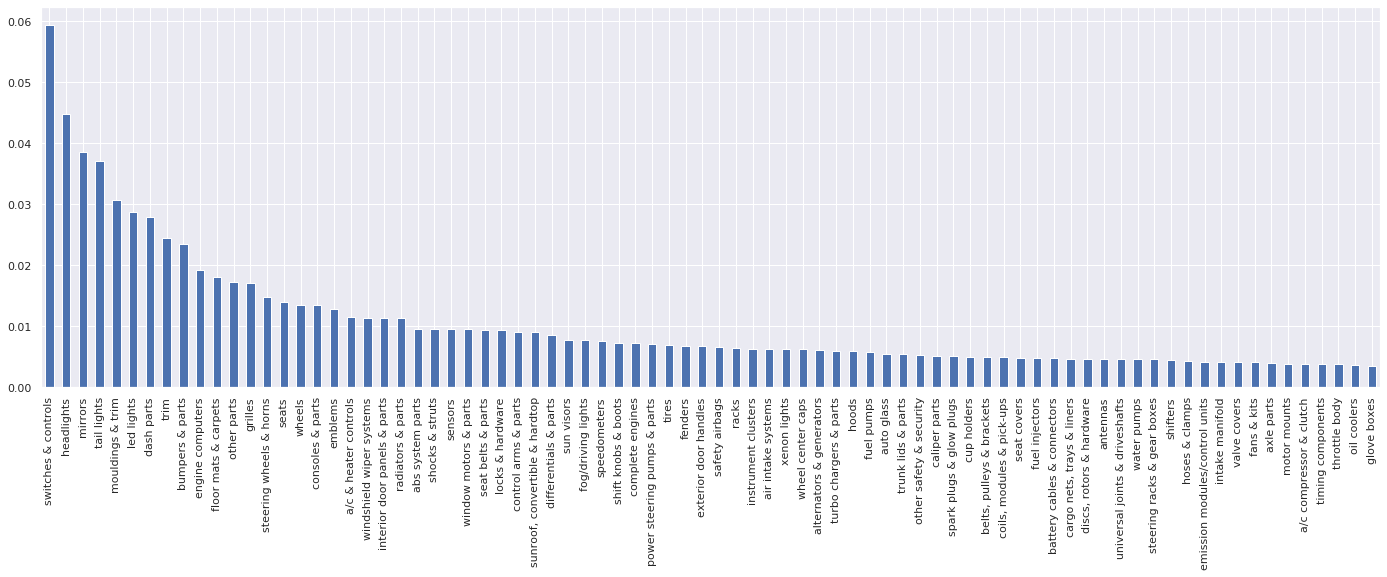

In [21]:
print(df_ebay.shape)
print(df_cats.catname.value_counts(normalize=True).head(8))
df_cats.catname.value_counts(normalize=True).head(80).plot(kind='bar',figsize=(24,7))

Instead of looking at the 'most popular part,' lets look at which combination of model and part appears the most in this dataset.  "Switches and Controls" for the BMW X5 is the #1 best-selling category out of nearly 100,000 BMW parts sold in the last 90 days. A graph of the top 80 BMW parts is below; Look at how drastically the graph drops from X5.switches_and_controls down to M3.switches_and_controls. 

Considering that multiple variants of the BMW 3-series shows up with switches_and_controls, (as well as 5-Series, X3, etc) it's not unreasonable to suggest that BMW interior electronics may need their quality re-evaluated.

x5.switches & controls      549
m3.switches & controls      342
325i.switches & controls    335
x5.headlights               322
328i.tail lights            296
x5.tail lights              292
x3.headlights               282
328i.switches & controls    270
Name: modelcat, dtype: int64


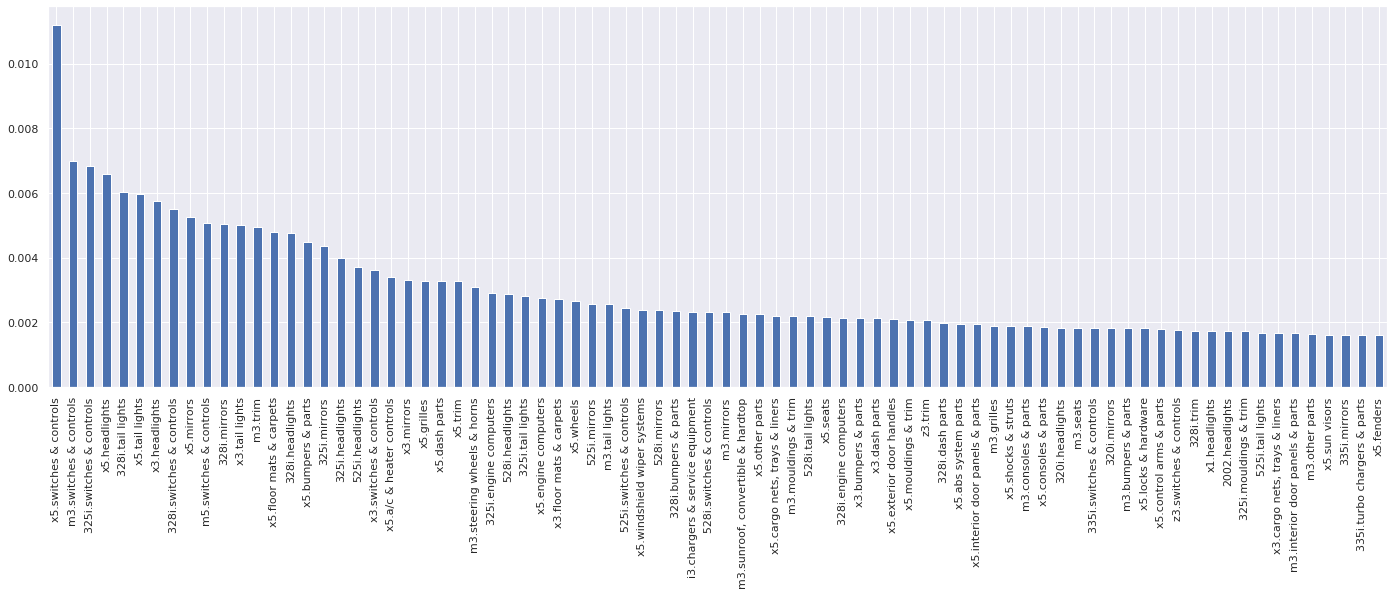

In [22]:
print(df_models.modelcat.value_counts().head(8))
df_models.modelcat.value_counts(normalize=True).head(80).plot(kind='bar',figsize=(24,7))

Which cars in general seem to show up the most in our dataset? Its reasonable to expect that the BMW 3-Series, being one the most-affordable and most-popular models, ranks high on this list because of sheer popularity. Yet the X5 model still exceeds sales of all other models multiplicatively.

0.07051995101540973


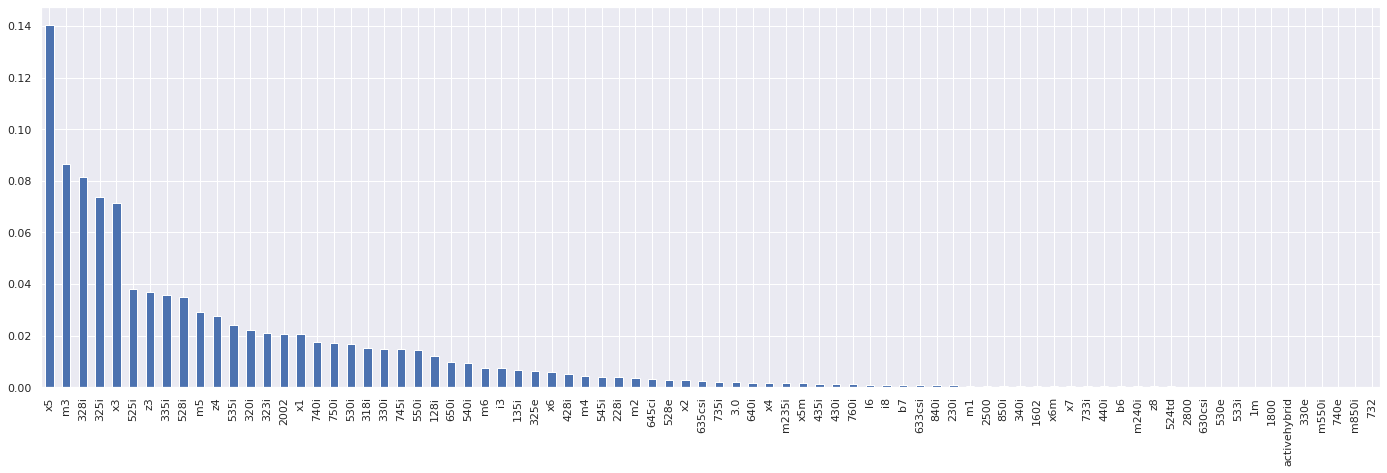

In [23]:
print(df_models.model.value_counts(normalize=True).head(8).mean())
df_models.model.value_counts(normalize=True).head(80).plot(kind='bar',figsize=(24,7))

Now that we know the X5 has generally the most-frequent-selling replacement parts out of all BMW's on eBay, lets see if we can distinguish between body styles of the X5. Which years of the X5 come up the most?

Using Natural Language Processing tools, I learned several things. Firstly, the word "X6" is often used together with the word X5, which suggests there may be many items that share fitment interchangability between the X5 and X6. (Sometimes different models share the same parts; engines, airbags, computer modules, etc.)

Next, i see that the most frequent body styles of X5 are the 2007-2013 model, and the 2000-2006 model. Both models seem to have a close number of records in this dataset. This may suggest that some of the flaws of the predecessor model were sort of 'carried over' into its successor model.

Looking at the graph below, parts like headlights and tailights usually rank highly universally, across mostly every make and model because you buy them if your vehicle ever gets damaged. (slow down when you're going around corners!) Compare this to items like switches or the air conditioning unit; Those are the types of parts that are replaced because they wore out or didnt last. In my opinion, this abrupt jump in sales for those parts is also evidence those types of parts may need extra attention in future models.

**30 most common words:
('x5', 6917)
('bmw', 6830)
('oem', 3529)
('e70', 1973)
('e53', 1857)
('front', 1370)
('rear', 1197)
('left', 1168)
('side', 1038)
('right', 1026)
('x6', 927)
('driver', 817)
('-', 765)
('passenger', 668)
('control', 655)
('door', 594)
('cover', 536)
('e71', 495)
('f15', 487)
('light', 468)
('switch', 438)
('black', 430)
('2007-2013', 430)
('2000-2006', 420)
('00-06', 406)
('air', 400)
('fits', 387)
('07-13', 368)
('headlight', 365)
('trim', 356)



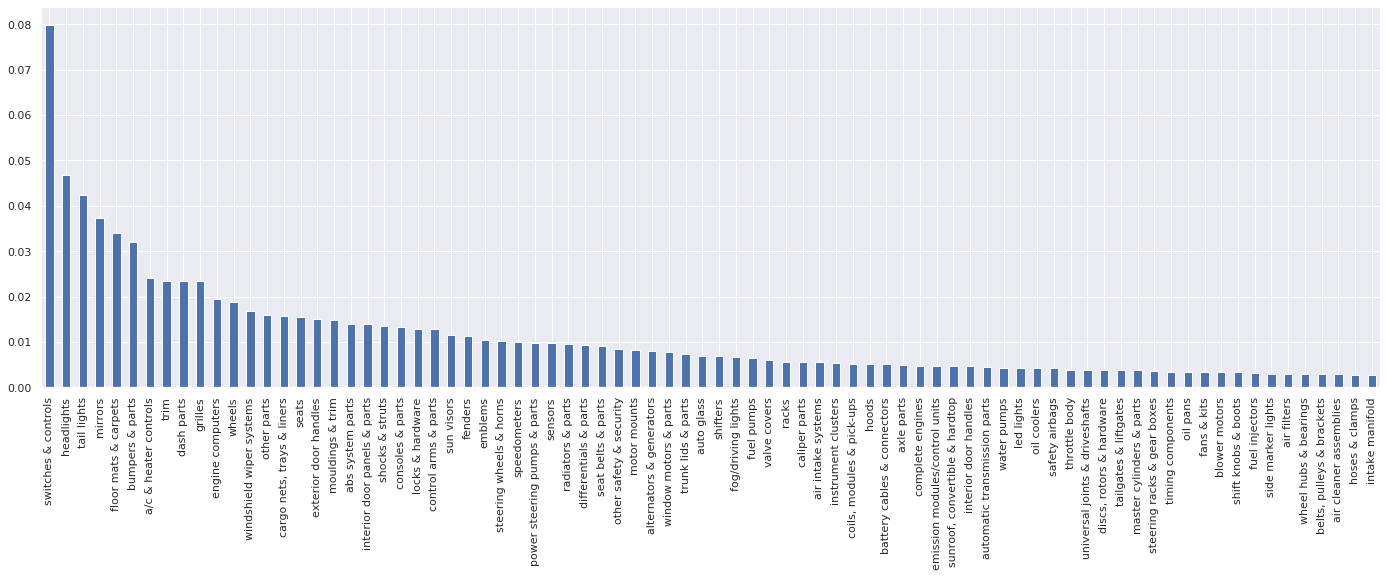

In [24]:
df_x5 = df_ebay[
    (df_ebay.model == 'x5') &
    (df_ebay.catname != 'other')]

list_allwords = []
list_alltitles = df_x5.title.tolist()

for title in list_alltitles:
  [
    list_allwords.append(word) for word in word_tokenize(
    ''.join([char for char in title if char.isalnum() 
    or char == ' ' or char == '-'])) 
    if not word in stop_words]

c = Counter(list_allwords)
print('**30 most common words:')
[print(i) for i in c.most_common(30)]
print()
df_x5.catname.value_counts(normalize=True).head(80).plot(kind='bar',figsize=(24,7))

# In conclusion, it appears that some of the best decisions an automaker like BMW could make, would be to improve the overall quality of their interior electronics. And based on the data about death and injury due to Driver Inattention/ Failure to Yield/ Unsafe Speed, not only do we need better-quality electronics - but also more Machine Learning models that can accurately predict a high-risk situation based on location. A simple "Accident Risk Warning Light" could make an impact on reducing injuries and deaths. 
</br>

# Thanks for viewing my notebook!